In [1]:
import pandas as pd
import numpy as np
import pickle
import random

import nltk
from nltk import FreqDist

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('words')
import matplotlib.pyplot as plt
%matplotlib  inline

Emoji prediction with Bag of Words approach

In [2]:
tweets = pd.DataFrame(pd.read_pickle('tweeter_df_procesed_str'))
labels = pd.read_table('tweet_by_ID_08_12_2017__04_04_11.txt.labels',header=None,names =['Emoji'])

df = pd.merge(tweets, labels, left_index=True, right_index=True)
df['Text'] = df['Text'].str.replace(r'[0-9]{1,3}','number')
df['Text'] = df['Text'].str.replace(r'#',' ')
df['Text'] = df['Text'].str.replace(r'@',' ')
df.head()

,Text,Emoji
0,"LoL West Covina , California",2
1,Things got little festive office RedRock… ...,17
2,Step explore ️ Ellis Island Cafe,0
3,user Cathedral Preparatory School,18
4,My baby bear Bubby is,1


Helper functions

In [2]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def convert_to_stem(text):
    tokens = []
    for word in  nltk.word_tokenize(text, language='english'):
        #if len(word) < 2:
            #continue
        tokens.append(stemmer.stem(word.lower()))
    return tokens

def convert_to_lem(text):
    tokens = []
    for word in  nltk.word_tokenize(text, language='english'):
        #if len(word) < 2:
            #continue
        tokens.append(lemmatizer.lemmatize(word.lower()))
    return tokens

def tokenize_on_whitespace(sent):
    result = []
    for w in WhitespaceTokenizer().tokenize(sent):
        result.append(w.lower())
    return result

def untokenize(lst):
    result = ''
    for w in lst:
        result = result + " "+ str(w)
    return result
def calculate_metrix(y_test,pred):


    print('F1 micro: {:.2f}'.format(f1_score(y_test, pred,average='micro')))
    print('F1 macro: {:.2f}'.format(f1_score(y_test, pred,average='macro')))



    print('Micro-averaged precision = {:.2f} (treat instances equally)'
          .format(precision_score(y_test, pred, average = 'micro')))
    print('Macro-averaged precision = {:.2f} (treat classes equally)'
          .format(precision_score(y_test, pred, average = 'macro')))
    print('Micro-averaged recall = {:.2f} (treat instances equally)'
          .format(recall_score(y_test, pred, average = 'micro')))
    print('Macro-averaged recall = {:.2f} (treat classes equally)'
          .format(recall_score(y_test, pred, average = 'macro')))
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = train_df['Emoji'].unique()
    tick_marks = np.arange(len(my_tags))
    target_names = tick_marks
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True Emoji')
    plt.xlabel('Predicted Emoji')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('acc: %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    #print('confusion matrix\n %s' % cm)
    #print('(row=expected, col=predicted)')
    calculate_metrix(predictions,target)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
def words_sort_by_freq(series, threshold, Flag_for_stem_tokinzer = True):
    threshold += 1
    if Flag_for_stem_tokinzer:
        df_tkn = series.apply(convert_to_stem)
    else:
        df_tkn = series.apply(convert_to_lem)
    df_array = df_tkn.values.tolist()
    flattend = []
    for row in df_array:
        flattend += row
    dist = FreqDist(flattend)
    sortedToken = sorted(list(set(flattend)), key=lambda token: dist[token], reverse=False)
    word_freq_sorted = [(token, dist[token]) for token in sortedToken]

    for idx in range(len(word_freq_sorted)):
        if word_freq_sorted[idx][1] == threshold:
            start = idx
            break
    return  word_freq_sorted[start:]
    #word_freq = [(line[0], line[1]) for line in word_to_freq[start:]])
def words_distribution_above_treshold(series, threshold=5, Flag_for_stem_tokinzer = True):
    word_freq_sorted = words_sort_by_freq(series, threshold, Flag_for_stem_tokinzer)
    previous_freq = word_freq_sorted[0][1]
    frequences = []
    number_of_words_with_freq = []
    word_counter = 0
    for line in word_freq_sorted:
        freq = line[1]
        word_counter += 1
        if freq  != previous_freq:
            frequences.append(previous_freq)
            number_of_words_with_freq.append(word_counter)
            word_counter = 0
        previous_freq = freq
    if word_freq_sorted[-1][1] == word_freq_sorted[-2][1]:
        frequences.append(freq)
        number_of_words_with_freq.append(word_counter)
    else:
        frequences.append(freq)
        number_of_words_with_freq.append(1)

    return (frequences, number_of_words_with_freq)
    
def words_with_freq_above_treshold(series, threshold=5, Flag_for_stem_tokinzer = True):
    word_freq_sorted = words_sort_by_freq(series, threshold, Flag_for_stem_tokinzer)
    result = [(line[0]) for line in word_freq_sorted]
    
    return result

In [ ]:
word_freqs, num_words = words_distribution_above_treshold(df['Text'], 2) 
vacabilary_words_above_treshold = words_with_freq_above_treshold(df['Text'], 2)
print("Total number of words: "+ str(len(vacabilary_words_above_treshold)))

In [6]:
word_freqs, num_words = words_distribution_above_treshold(df['Text'], 2,False) 
vacabilary_words_above_treshold = words_with_freq_above_treshold(df['Text'], 2, False)
print("Total number of words: "+ str(len(vacabilary_words_above_treshold)))


Total number of words: 48767


Shuffle data and split in train, test and dev sets

In [ ]:
perm = np.random.permutation(df.index)
df = df.reindex(perm)

num_rows = df.shape[0]
train_size =  0.91
test_size = 0.06

train_rows = int(num_rows*train_size)
test_rows = train_rows + int(num_rows*test_size)

test_df = df.iloc[train_rows:test_rows,:]

valid_df = df.iloc[test_rows:,:]

train_df = df.iloc[:train_rows,:]
print(train_df.shape, test_df.shape, valid_df.shape)

In [217]:
# Save the data
#train_df.to_pickle('Tra.p')
#test_df.to_pickle('Tes.p')
#valid_df.to_pickle('Val.p')

In [5]:
train_df = pd.read_pickle('Tra.p')
test_df = pd.read_pickle('Tes.p')
valid_df = pd.read_pickle('Val.p')


Naive Bayes model

(437474, 33382)
0.4058383025932603
acc: 0.4058383025932603
F1 micro: 0.41
F1 macro: 0.26
Micro-averaged precision = 0.41 (treat instances equally)
Macro-averaged precision = 0.27 (treat classes equally)
Micro-averaged recall = 0.41 (treat instances equally)
Macro-averaged recall = 0.30 (treat classes equally)


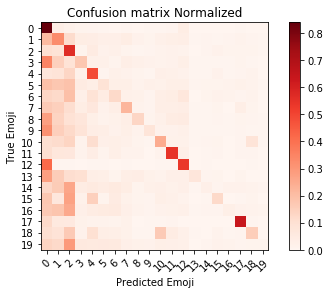

In [6]:
def prediction_of_models(model,X_train_vectorized, X_test_vectorized, y_train,y_test):
    predictions = model.predict(X_test_vectorized)
    print(metrics.accuracy_score(y_test, predictions))
    evaluate_prediction(predictions, y_test)

def Train_clf(train_df, test_df, clf, preselected=False ,vocabilary_of_preselected_words = None):
    X_train = train_df['Text']
    y_train = train_df['Emoji']
    X_test = test_df['Text']
    y_test = test_df['Emoji']  
    
    if preselected:
        vect = CountVectorizer(tokenizer = convert_to_stem, vocabulary = vocabilary_of_preselected_words).fit(X_train)
        
    else:
        vect = CountVectorizer(tokenizer = convert_to_stem, min_df=4).fit(X_train)
    

    
    X_train_vectorized = vect.transform(X_train)
    X_test_vectorized = vect.transform(X_test)
    print(X_train_vectorized.shape)
    model = clf.fit(X_train_vectorized, y_train)
    prediction_of_models(model, X_train_vectorized, X_test_vectorized, y_train, y_test)
    
    
    return model , X_test_vectorized

CLF = MultinomialNB()
CLF, X_test_vectorized = Train_clf(train_df.iloc[:,:], test_df, CLF)

Feature selection with chi-square 

In [7]:
def chi_feature_selection(X_train, y_train, vocabilary_of_preselected_words, num_words):
    vectorizer_w = TfidfVectorizer(ngram_range=(1, 2), vocabulary = vocabilary_of_preselected_words, tokenizer =convert_to_stem)
    X_for_word_selection = vectorizer_w.fit_transform(X_train)
    chi2score = chi2(X_for_word_selection, y_train.astype(str))[1]
    wscores = list(zip(vectorizer_w.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1],reverse=False)
    wchi2 = [x[0] for x in wchi2]
    return wchi2[:num_words]


def chi_sq_top(train_df, num_words=100):
    result = []
    words_above_treshold = words_with_freq_above_treshold(train_df.copy()['Text'],4)
    for label in train_df['Emoji'].unique():
        df_new = train_df.copy()

        df_new['Emoji'] = (df_new['Emoji'] == label)
        X_train = df_new['Text']
        y_train = df_new['Emoji']

        top = chi_feature_selection(X_train, y_train, words_above_treshold, num_words)
        words_above_treshold = list(set(words_above_treshold) - set(top))
        result = result + top
    return result
chi_selected = chi_sq_top(train_df)

In [21]:
print(len(list(set(chi_selected))))

2000


Feature selection with decision tree


In [ ]:
def CountVectorizer_tree_feature_selection(X_train, y_train, words_above_treshold,num_words):
    clf = DecisionTreeClassifier(criterion="entropy")
    vect = CountVectorizer(tokenizer = convert_to_stem, vocabulary=words_above_treshold).fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    model = clf.fit(X_train_vectorized, y_train)
    top_idx = clf.feature_importances_.argsort()[-num_words:][::-1]


    names = vect.get_feature_names()
    names = np.array(names)

    feature_names = names[top_idx]
    return feature_names

def tree_selection(train_df, num_words, chi_selected):
    result = []
    words_above_treshold = words_with_freq_above_treshold(df.copy()['Text'],4)
    words_above_treshold = list(set(words_above_treshold) - set(chi_selected))
    for label in train_df['Emoji'].unique():
        df_new = train_df.copy()
        df_new['Emoji'] = (df_new['Emoji'] == label)
        X_train = df_new['Text']
        y_train = df_new['Emoji']
        df_new = train_df.copy()

        top = CountVectorizer_tree_feature_selection(X_train, y_train, words_above_treshold,num_words)
        words_above_treshold = list(set(words_above_treshold) - set(top))
        result = result + list(top)
    return result
tree_selected = tree_selection(train_df.copy().iloc[:,:],  150, chi_selected)

Train a model with one SVM for each class. The conflicts are resolved with a global SVM which is train only on the
most informative words

In [ ]:
def locals_SVM_idf(train_df, test_df):
    models = []
    
    X_train = train_df['Text']
    X_test = test_df ['Text']
    
    vect = TfidfVectorizer(tokenizer = convert_to_stem, min_df=5).fit(X_train)
    
    X_train_vectorized = vect.transform(X_train)
    X_test_vectorized = vect.transform(X_test)
    
    for label in range(len(train_df['Emoji'].unique())):
        new_train_df = train_df.copy()
        new_train_df['Emoji'] = (new_train_df['Emoji'] == label)
        y_train = new_train_df['Emoji']
        model = LinearSVC(C=0.5).fit(X_train_vectorized, y_train)
        models.append((model,label))
    return X_test_vectorized, models


def global_SVM(train_df, test_df, clf):
    
    X_train = train_df['Text']
    y_train = train_df['Emoji']
    X_test = test_df ['Text']
    words_in_clf = tree_selected + chi_selected
    vect = CountVectorizer(tokenizer = convert_to_stem, vocabulary=words_in_clf).fit(X_train)
    
    X_train_vectorized = vect.transform(X_train)    
    X_train_vectorized = normalize(X_train_vectorized, norm='l2')
    
    X_test_vectorized = vect.transform(X_test)
    X_test_vectorized = normalize(X_test_vectorized, norm='l2')
    
    global_model = clf.fit(X_train_vectorized, y_train)

    
    return X_test_vectorized, global_model

        
def fit_predict(train_df, test_df, clf):
        
        X_test_local, local_models = locals_SVM_idf(train_df.copy(),test_df.copy())
        X_test_global, global_model = global_SVM(train_df, test_df, clf)
        local_df = pd.DataFrame(columns= range(len(train_df['Emoji'].unique())))
        for idx in range(len(local_models)):
            label = local_models[idx][1]
            model = local_models[idx][0]
            local_pred = model.predict(X_test_local)
            
                
            local_df[label]= local_pred
        
        local_r = local_df.sum(axis=1)

        local_final_pred = local_df[local_r == 1].idxmax(axis=1)
        #local_final_pred = local_df[local_df['local_result'] == 1].dropna(subset=["local_result"]).idxmax(axis=1)
        global_pred = global_model.predict(X_test_global)
        global_pred[local_final_pred.index] = local_final_pred
        evaluate_prediction(global_pred, test_df['Emoji'])
        return #global_pred
fit_predict(train_df, test_df, LinearSVC(C=1))

acc: 0.4359658854527805
F1 micro: 0.44
F1 macro: 0.28
Micro-averaged precision = 0.44 (treat instances equally)
Macro-averaged precision = 0.34 (treat classes equally)
Micro-averaged recall = 0.44 (treat instances equally)
Macro-averaged recall = 0.29 (treat classes equally)


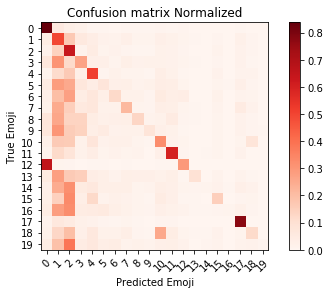

In [112]:
fit_predict(train_df, valid_df, LinearSVC(C=1))